In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # Keep for potential future use
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, precision_recall_fscore_support,f1_score, recall_score, accuracy_score
import gdown # Library to download from Google Drive
from sklearn.impute import SimpleImputer # Import imputer

# Define color codes
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
RESET = "\033[0m"  # Reset to default

In [2]:
#Alternativelly use the combined SECOM dataset csv in the dataset subfolder
# Define the dataset folder path (the files are in a subfolder called dataset)
from pathlib import Path

dataset_folder = Path('dataset')
dataset_filename= 'SECOM_combined_dataset.csv'

print(f"Attempting to open the combined file {dataset_filename} saved locally in the folder {dataset_folder}")
try:
     output_file = dataset_folder / dataset_filename
     print(f'File successfully opened.')
except FileNotFoundError as e:
     print(f'File not found: {e}')
except Exception as e:
     print(e)

Attempting to open the combined file SECOM_combined_dataset.csv saved locally in the folder dataset
File successfully opened.


In [3]:
# --- 2. Load Data using Pandas (Assuming Header IS Present) ---
try:
    # FIX: Remove header=None to let Pandas read the first row as header
    data = pd.read_csv(output_file)
    print(f"Data loaded successfully from {output_file} with shape: {data.shape}")
    # Display first few rows and info to check data types
    print("\nFirst 5 rows of loaded data:")
    print(data.head())
    print("\nData info:")
    data.info()
except Exception as e:
    print(f"Failed to load data from {output_file}: {e}")
    exit()

Data loaded successfully from dataset\SECOM_combined_dataset.csv with shape: (1567, 591)

First 5 rows of loaded data:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0    3030.93    2564.00  2187.7333  1411.1265     1.3602      100.0   
1    3095.78    2465.14  2230.4222  1463.6606     0.8294      100.0   
2    2932.61    2559.94  2186.4111  1698.0172     1.5102      100.0   
3    2988.72    2479.90  2199.0333   909.7926     1.3204      100.0   
4    3032.24    2502.87  2233.3667  1326.5200     1.5334      100.0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_581  feature_582  \
0    97.6133     0.1242     1.5005     0.0162  ...          NaN       0.5005   
1   102.3433     0.1247     1.4966    -0.0005  ...     208.2045       0.5019   
2    95.4878     0.1241     1.4436     0.0041  ...      82.8602       0.4958   
3   104.2367     0.1217     1.4882    -0.0124  ...      73.8432       0.4990   
4   100.3967     0.1235     1.5031    -0.0031  ...    

In [19]:
#Removing constant features form the dataset
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
def removeConstantFeatures(X_df):
    # Assuming X is a NumPy array or a DataFrame, and y is your target
    # If X is a DataFrame, you can also track column names
    is_dataframe = hasattr(X_df, 'columns')
    original_features = X_df.columns if is_dataframe else np.arange(X_df.shape[1])

    # Step 1: Remove constant features
    vt = VarianceThreshold(threshold=0.0)
    X_reduced = vt.fit_transform(X_df)

    # Identify kept and removed features
    kept_mask = vt.get_support()
    removed_features = original_features[~kept_mask]
    kept_features = original_features[kept_mask]

    # Convert to DataFrame if original was DataFrame
    X_cleaned_df = pd.DataFrame(X_reduced, columns=kept_features) if is_dataframe else X_reduced

    # Print message
    print(f"Removed {len(removed_features)} constant feature(s) from the original dataset:")
    print(list(removed_features))

    return X_cleaned_df


In [22]:
# --- 3. Prepare Data ---
if data.shape[1] > 1:
    # Assume last column is target 'y', all others are features 'X'
    feature_names = data.columns[:-1].tolist() # Get actual feature names from header
    X_df = data[feature_names] # Select feature columns using names
    y_series = data.iloc[:, -1] # Select target column by position

    X_df = removeConstantFeatures(X_df) #Removes constant features from the original dataset to avoid feeding non constribuiting features to the reducer
    #feature_names_after_removing_constant_features = X_df.columns

    #print(f"\nCurrent Feature names extracted from header: {feature_names[:5]}... (Total: {len(feature_names)})")
    print(f"\nKept Feature names: {X_df.columns[0:6].to_list()}... (Total: {len(X_df.columns)})")

    # --- Keep Robust Cleaning Steps ---
    # Convert non-numeric strings to numeric, coercing errors, otherwise-> NaN
    X_df_numeric = X_df.apply(pd.to_numeric, errors='coerce')
    y_series_numeric = pd.to_numeric(y_series, errors='coerce')

    # Handle potential NaN values resulting from coercion or missing values in original file
    imputer_X = SimpleImputer(strategy='mean')
    X_imputed = imputer_X.fit_transform(X_df_numeric)

    missing_labels_count = y_series_numeric.isna().sum()
    
    imputer_y = SimpleImputer(strategy='most_frequent') #changed strategy from mean to most frequent since we have binary labels
    y_imputed = imputer_y.fit_transform(y_series_numeric.values.reshape(-1, 1)).flatten()

    # Check for NaNs after imputation (should only happen if a whole column was non-numeric/NaN)
    if np.isnan(X_imputed).any() or np.isnan(y_imputed).any():
        print("Warning: NaNs still present after imputation. Check columns with all invalid values.")
        # Consider more advanced imputation or dropping problematic columns/rows if this occurs

    X_df = X_imputed
    y = y_imputed

    print(f"Features shape after cleaning: {X_df.shape}")
    
    print(f"Number of missing labels to be imputed: {missing_labels_count}")
    print(f"Target shape after cleaning: {y.shape}")
    n_features_loaded = X_df.shape[1] # Keep track of the number of features

else:
    print("Error: Loaded data has only one column. Cannot separate features and target.")
    exit()

Removed 116 constant feature(s) from the original dataset:
['feature_5', 'feature_13', 'feature_42', 'feature_49', 'feature_52', 'feature_69', 'feature_97', 'feature_141', 'feature_149', 'feature_178', 'feature_179', 'feature_186', 'feature_189', 'feature_190', 'feature_191', 'feature_192', 'feature_193', 'feature_194', 'feature_226', 'feature_229', 'feature_230', 'feature_231', 'feature_232', 'feature_233', 'feature_234', 'feature_235', 'feature_236', 'feature_237', 'feature_240', 'feature_241', 'feature_242', 'feature_243', 'feature_256', 'feature_257', 'feature_258', 'feature_259', 'feature_260', 'feature_261', 'feature_262', 'feature_263', 'feature_264', 'feature_265', 'feature_266', 'feature_276', 'feature_284', 'feature_313', 'feature_314', 'feature_315', 'feature_322', 'feature_325', 'feature_326', 'feature_327', 'feature_328', 'feature_329', 'feature_330', 'feature_364', 'feature_369', 'feature_370', 'feature_371', 'feature_372', 'feature_373', 'feature_374', 'feature_375', 'fe

In [23]:

# --- 4. Split Data for Fitness Evaluation ---
# Using the cleaned X and y, with stratify helps maintain the proportion of class labels
X_train, X_val, y_train, y_val = train_test_split(X_df, y, test_size=0.3, random_state=42, stratify=y)
n_features = X_train.shape[1] # Use the actual number of features

# Map -1 → 0, 1 → 1
y_train = np.where(y_train == -1, 0, y_train)
y_val = np.where(y_val == -1, 0, y_val)

print(f"\nTraining features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f'Unique values in original labels: {np.unique(y)}')
print(f'Unique values in training labels after mapping negative class (-1) to 0: {np.unique(y_train)}')
print(f'Unique values in validation labels after mapping negative class (-1) to 0: {np.unique(y_val)}')


Training features shape: (1096, 474)
Validation features shape: (471, 474)
Unique values in original labels: [-1  1]
Unique values in training labels after mapping negative class (-1) to 0: [0 1]
Unique values in validation labels after mapping negative class (-1) to 0: [0 1]


In [24]:
#The expected number of selected features is d ⊆ n_features, this constraint must be set up since the first population
# to make more likely for the algorithm to focus on small subsets instead of larger ones in further generations.
#We set the chance of each gene being 1 in the initial population P to a value of d/D
def initialize_population(d, pop_size, n_features):
    probability_for_1 = d/n_features
    probability_for_0 = 1 - probability_for_1
    
    print(f'-Building Initial population of size: {pop_size} with approximately {d} features per individual from a max of {n_features}')
    
    pop = np.random.choice([0, 1], size=(pop_size, n_features), p=[probability_for_0, probability_for_1])    
    
    # Ensure initial individuals are not all zeros
    for i in range(pop_size):
        if not pop[i].any:
            #then randomly sets one feature to 1.
            pop[i, np.random.randint(0, n_features)] = 1
    return pop

OVERSAMPLING OF THE MINORITY CLASS TEST


In [37]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 2. Feature scaling (optional but often helps RF slightly)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)

# 3. SMOTE oversampling (only on train set!)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [44]:
model = RandomForestClassifier(n_estimators=300, # Reduced from 50
                                random_state=42,
                                class_weight= None,  # 'balanced' only if data is no SMOTEd
                                n_jobs=-1) # Use n_jobs=-1 for parallelization
# --- TUNING POINT ---

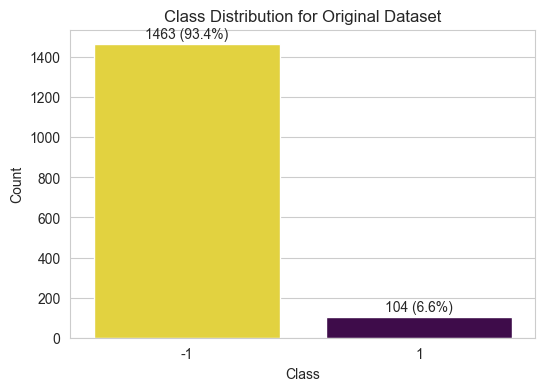

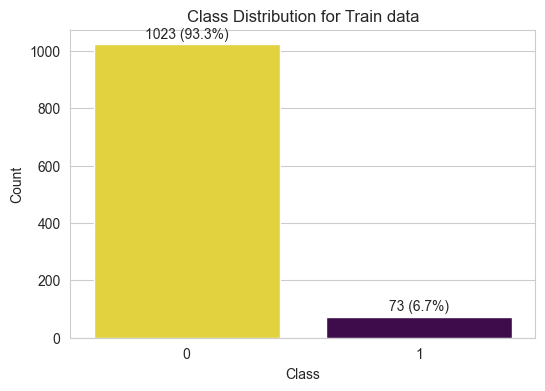

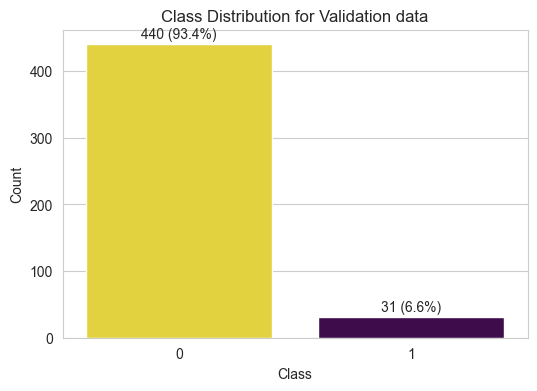

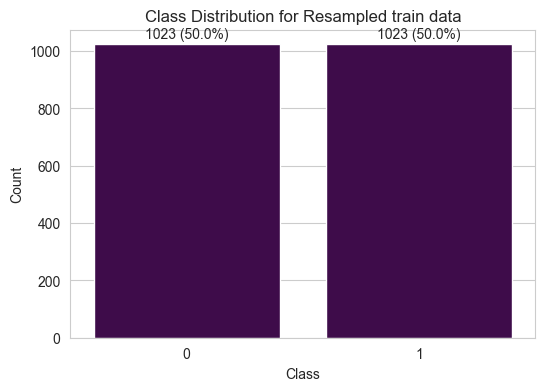

In [45]:
#To visualize the distribution of the labels, in the case of SECOM is imbalanced
def plotLabelsDistribution(label_array, data_name='default_name'):
    data = pd.DataFrame({'label': label_array})

    # Count the occurrences of each class
    class_counts = data['label'].value_counts().sort_index()
    class_percentages = class_counts / class_counts.sum() * 100

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(6,4))
    #sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis", hue=class_counts, legend=False)

    plt.title(f'Class Distribution for {data_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Annotate counts and percentages on bars
    for i, (count, perc) in enumerate(zip(class_counts.values, class_percentages.values)):
        plt.text(i, count + max(class_counts.values)*0.01, f'{count} ({perc:.1f}%)', 
                ha='center', va='bottom', fontsize=10)

    plt.show()

#plot LAbel distributions
plotLabelsDistribution(y,'Original Dataset')
plotLabelsDistribution(y_train,'Train data')
plotLabelsDistribution(y_val,'Validation data')
plotLabelsDistribution(y_resampled,'Resampled train data')

In [46]:

print(np.unique(y))
print(np.unique(y_train))
print(np.unique(y_val))
print(np.unique(y_resampled))


[-1  1]
[0 1]
[0 1]
[0 1]


In [47]:
#TEst with ANOVA
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=50)
X_selected = selector.fit_transform(X_resampled, y_resampled)

selected_indices = selector.get_support()  # Boolean mask of selected features
X_val_sel = X_val[:, selected_indices]


# 4. Random Forest with class weights
#model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_selected, y_resampled)

#print(f'\nY predicted: {y_pred}')
# 5. Predict probabilities
y_probs = model.predict_proba(X_val_sel)[:, 1]

# 6. Threshold tuning (try 0.2 instead of default 0.5)
threshold = 0.2
y_pred = (y_probs > threshold).astype(int)
    
# 7. Evaluate
print(f'Report with {len(selected_indices)} selected features from ANOVA')
print(classification_report(y_val, y_pred, digits=4, zero_division=0))
print("F1-score:", f1_score(y_val, y_pred))

Report with 474 selected features from ANOVA
              precision    recall  f1-score   support

           0     0.9701    0.7364    0.8372       440
           1     0.1533    0.6774    0.2500        31

    accuracy                         0.7325       471
   macro avg     0.5617    0.7069    0.5436       471
weighted avg     0.9163    0.7325    0.7986       471

F1-score: 0.25


In [49]:
d=50
pop_size =10
population = initialize_population(d,pop_size, n_features)

for ind in population:       
    #print(f'\nIndividual sample: {individual}')
    #print(f'Individual shape: {individual.shape}')
    #print(individual[0])

    individual = np.array(ind)  #Ensure it's a NumPy array
    selected_indices = np.where(individual == 1)[0] # Get indices where bit is 1
    #print(f'selected indices: {selected_indices}')
    num_selected_features = len(selected_indices)
    print(f'\nNumber Selected features: {num_selected_features}')



    # Select corresponding columns from train/validation sets
    X_train_sel = X_resampled[:, selected_indices]
    X_val_sel = X_val[:, selected_indices]

    try:        
        # 4. Random Forest with class weights
        model = RandomForestClassifier(class_weight= None, random_state=42)
        model.fit(X_train_sel, y_resampled)

        #print(f'\nY predicted: {y_pred}')
        # 5. Predict probabilities
        y_probs = model.predict_proba(X_val_sel)[:, 1]

        # 6. Threshold tuning (try 0.2 instead of default 0.5)
        threshold = 0.2
        y_pred = (y_probs > threshold).astype(int)
           
        # 7. Evaluate
        print(classification_report(y_val, y_pred, digits=4, zero_division=0))
        print("F1-score:", f1_score(y_val, y_pred))
        
        #penalty = penalty_coef*abs(num_selected_features - num_desired_features)
        
        #fitness = score - penalty

    except ValueError as e:
        # Catch potential errors during fitting/prediction if data issues remain
        print(f"Error during model fitting/prediction: {e}")

-Building Initial population of size: 10 with approximately 50 features per individual from a max of 474

Number Selected features: 55
              precision    recall  f1-score   support

           0     0.9578    0.6705    0.7888       440
           1     0.1104    0.5806    0.1856        31

    accuracy                         0.6645       471
   macro avg     0.5341    0.6255    0.4872       471
weighted avg     0.9020    0.6645    0.7491       471

F1-score: 0.18556701030927836

Number Selected features: 55
              precision    recall  f1-score   support

           0     0.9582    0.6773    0.7936       440
           1     0.1125    0.5806    0.1885        31

    accuracy                         0.6709       471
   macro avg     0.5353    0.6290    0.4910       471
weighted avg     0.9025    0.6709    0.7538       471

F1-score: 0.18848167539267016

Number Selected features: 50
              precision    recall  f1-score   support

           0     0.9656    0.6386   

In [13]:
d=100
pop_size =10
population = initialize_population(d,pop_size, n_features)

for ind in population:       
    #print(f'\nIndividual sample: {individual}')
    #print(f'Individual shape: {individual.shape}')
    #print(individual[0])

    individual = np.array(ind)  #Ensure it's a NumPy array
    selected_indices = np.where(individual == 1)[0] # Get indices where bit is 1
    #print(f'selected indices: {selected_indices}')
    num_selected_features = len(selected_indices)
    print(f'\nNumber Selected features: {num_selected_features}')



    # Select corresponding columns from train/validation sets
    X_train_sel = X_train[:, selected_indices]
    X_val_sel = X_val[:, selected_indices]

    try:        
        model.fit(X_train_sel, y_train)
        y_pred = model.predict(X_val_sel)

        #print(f'\nY predicted: {y_pred}')
        
        # Fitness = Negative MSE (maximization) - Penalty for feature count
        #mse = mean_squared_error(y_val, y_pred)        
        #fitness = -mse - penalty_coef * num_selected_features
        #score = mean_squared_error(y_val, y_pred)
        #print(f'\nMSE: {score}')        

        #f1 score more suitable for imbalanced (binary) datsaet
        #penalty discourages solutions that are significantly larger or smaller than the target subset size 
        score = accuracy_score(y_val,y_pred)        
        print(f'\naccuracy: {score}')
        
        score = f1_score(y_val,y_pred,average='binary', pos_label=1)
        print(f'\nf1_SCORE: {score}')

        score = recall_score(y_val,y_pred,average='binary')        
        print(f'\nrecall: {score}')

        score = precision_score(y_val,y_pred, zero_division=0, pos_label=1,average='binary')        
        print(f'\nprecision: {score}')

        score = precision_recall_fscore_support(y_val,y_pred, zero_division=0, pos_label=1, average='binary', beta=1)        
        print(f'\nPrecision_recall: {score}')
        print(f'----------'*60)

        #penalty = penalty_coef*abs(num_selected_features - num_desired_features)
        
        #fitness = score - penalty

    except ValueError as e:
        # Catch potential errors during fitting/prediction if data issues remain
        print(f"Error during model fitting/prediction: {e}")

-Building Initial population of size: 10 with approximately 100 features per individual from a max of 590

Number Selected features: 109

accuracy: 0.9341825902335457

f1_SCORE: 0.0

recall: 0.0

precision: 0.0

Precision_recall: (0.0, 0.0, 0.0, None)
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Number Selected features: 108

accuracy: 0.9341825902335457

f1_SCORE: 0.0

recall: 0.0

precision: 0.0

Precision_recall: (0.0, 0.0, 0.0, None)
-